<a href="https://colab.research.google.com/github/marmal88/Cars/blob/main/Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Identification dataset

In [1]:
jupyter nbconvert Cars.ipynb --to python
pipreqs --force .
!pip install -r requirements.txt

SyntaxError: invalid syntax (3716757621.py, line 1)

# Preliminary EDA from csv

In [27]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os

In [28]:
names_df = pd.read_csv('data/annotations/class_names.csv', header=None)
names_df.rename(columns={0:"class_names"}, inplace=True)
names_df.index = (np.arange(1, len(names_df) + 1))

data_df = pd.read_csv('data/annotations/cars_annos.csv', sep=";")

In [29]:
df = pd.merge(data_df, names_df, how='inner', left_on="class", right_index=True)
col = {x:x.lower() for x in df.columns}
df.rename(columns=col, inplace=True)

df.head()

,image,x1,y1,x2,y2,class,test,class_names
0,000001.jpg,112,7,853,717,1,0,AM General Hummer SUV 2000
1,000002.jpg,48,24,441,202,1,0,AM General Hummer SUV 2000
2,000003.jpg,7,4,277,180,1,0,AM General Hummer SUV 2000
3,000004.jpg,33,50,197,150,1,0,AM General Hummer SUV 2000
4,000005.jpg,5,8,83,58,1,0,AM General Hummer SUV 2000


In [30]:
df.shape

(16185, 8)

In [31]:
# Check to see if the dataset split is already fair by ensuring stratification of classes over the train and test set
test_df = df.loc[df["test"]==1]
train_df = df.loc[df["test"]==0]

print(f"total number of classes entire dataset {df['class'].nunique()}")
print(f'total number of classes in test set {test_df["class"].nunique()}')
print(f'total number of classes in test set {train_df["class"].nunique()}')

total number of classes entire dataset 196
total number of classes in test set 196
total number of classes in test set 196


In [32]:
train_df.to_csv("data/annotations/train_df.csv", index=False)
train_df.to_csv("data/annotations/test_df.csv", index=False)

015135.jpg 145 101 890 648 745 547 Suzuki SX4 Sedan 2012
000523.jpg 33 148 598 368 565 220 Acura ZDX Hatchback 2012
002639.jpg 519 438 1460 1152 941 714 BMW X6 SUV 2012
004151.jpg 23 27 555 326 532 299 Cadillac SRX SUV 2012
000518.jpg 17 62 425 314 408 252 Acura ZDX Hatchback 2012


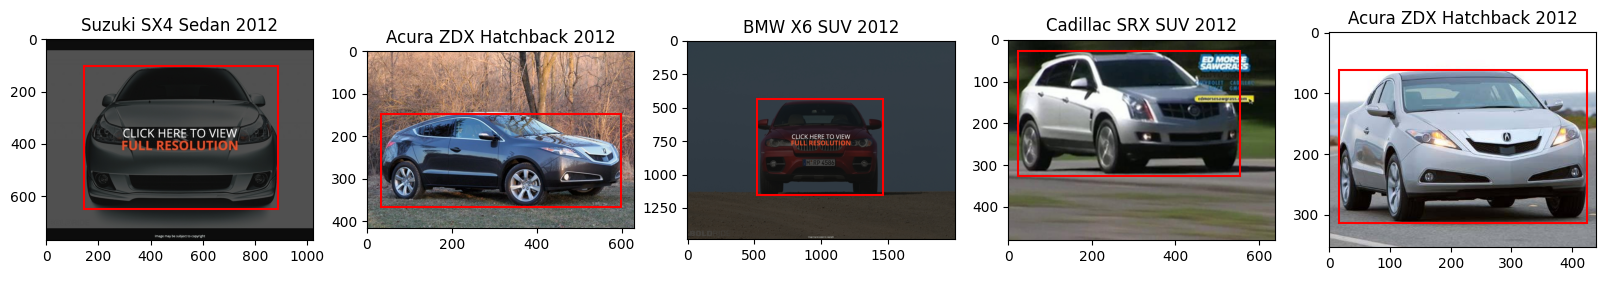

In [33]:
# Random check to see if bounding boxes are able to completely cover the car in question

plt.figure(figsize=(20,20))
for i in range(5):
    rand = np.random.randint(len(df))
    img_name, x1, y1, x2, y2, _, _, class_names = df.iloc[rand,:]

    width = x2-x1
    height = y2-y1
    print(img_name, x1, y1, x2, y2, width, height, class_names)
    
    img = Image.open(f'data/car_ims/{img_name}')
    ax=plt.subplot(1,5,i+1)
    plt.imshow(img)
    rect = Rectangle((x1, y1), width, height, linewidth=1.5, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.title(f"{class_names}")

plt.show()

In [8]:
# Check to see if there are different modes in the dataset RGB vs RGBA, seems like all are jpg
df["image"].apply(lambda x: os.path.splitext(x)[1]).unique()

array(['.jpg'], dtype=object)

# Model Training



In [100]:
import torchvision
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, utils 
import torchvision.transforms.functional as TF
import torch.nn as nn
from torch.optim import Adam
from torchvision.models import resnet50, ResNet50_Weights
import os
from PIL import Image
import matplotlib.pyplot as plt
from typing import Dict

In [95]:
# set parameters for training
train_df = pd.read_csv("data/annotations/train_df.csv") 

num_class = train_df["class"].nunique()
epochs = 30
batch_size = 32

In [96]:
class Dataset(Dataset):

    def __init__(self, csv_file:str, root_dir:str, transform=None)->Dict:
        """ Curated Dataset function
        Args:
            csv_file (str): Path to the csv file with annotations.
            root_dir (str): Directory with all the images.
            transform (_type_, optional): Optional transform to be applied on a sample. Defaults to None.
        Returns:
            Dict: Sample dictionary
        """        
        self.dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.image[idx])
        img = Image.open(img_name)
        label = self.dataframe.class_names[idx]
        left, top, right, bottom = self.dataframe.x1[idx], self.dataframe.y1[idx], self.dataframe.x2[idx], self.dataframe.y2[idx]
        sample = {'image': img, 'left':left, 'top':top, 'right':right, 'bottom':bottom, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [97]:
class CustomCrop(object):
    def __call__(self, sample: Dict)->Image:
        """ Custom crop function to return the boundary box image
        Args:
            sample (Dict): dictionary with the same information
        Returns:
            Image: returns the cropped image
        """        
        img = sample['image']
        print(type(img))
        left, top, right, bottom = sample['left'], sample['top'], sample['right'], sample['bottom']
        label = sample["label"]
        width = right-left
        height = bottom-top

        img = TF.crop(img, top, left, height, width)

        return img

In [98]:
# normalize mean and std from imagenet pretrained
# mean and standard dev as per pre-trained imagenet dataset (https://pytorch.org/hub/pytorch_vision_resnet/)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = T.Compose([
                CustomCrop(),
                T.Resize([224,224]),
                T.ToTensor(),
                T.Normalize(mean=mean, std=std),
                ])

path_to_data = os.path.join(os.getcwd(), "data/car_ims")

dataset = Dataset(csv_file="data/annotations/train_df.csv", root_dir=path_to_data, transform=transform)

DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)

In [ ]:
class ClassifierModel(nn.Module):

    def __init__(self, num_class:int):
        """ Initializes the ClassifierModel instance
            The super here inherits the functions from the base torch nn.Module, allowing 
            us to create layers and convolutions.
            Added a dropout to the last linear layer and amended out_features to num_class
        Args:
            num_class (int): The number of classes in the classification problem.
        """        
        super().__init__()
        self.model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
                            nn.Dropout(0.5), 
                            nn.Linear(num_ftrs, num_class)
                            )

    def forward(self, x:torch.Tensor)-> torch.Tensor:
        x = self.model(x)
        return x

In [ ]:

model = ClassifierModel(num_class)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001) 

In [ ]:
for epoch in range(epochs):
    print(f"current epoch {epoch}")
    for img, label in train_loader:
        for param in model.parameters():
            param.grad = None
        output = model(img)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    correct = 0
    total = 0
    for img, label in train_loader:
        print("Evaluation loop starts")
        model.eval()
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        torch.save("models/")
    print(f"Accuracy of the model on the test set: {100 * correct / total}%")